# Lab 01: Sentiment analysis

Team members:
- SADI Lina
- TAGZIRT Elissa
- MESSAR Cylia
- KHERROUBI Ilhem
- KEDADSA Islam Chakib

In [1]:
import nltk
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras

## 1. Data preparation


### 1.1. Data lecture

In [2]:
import pandas as pd

data=pd.read_csv("finance_sentiment.csv")
data.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [3]:
from sklearn.model_selection import train_test_split

x=data['Sentence']
y=data['Sentiment']

Xtxt_train, Xtxt_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)
Xtxt_train.shape

(4089,)

In [4]:
from sklearn.preprocessing import LabelBinarizer
# TODO: OneHot encoding of Y (the output)
# =======================================================
lb = LabelBinarizer()
lb.fit(Y_train)

y_train_one_hot=lb.transform(Y_train)
y_test_one_hot=lb.transform(Y_test)


y_train_one_hot
y_test_one_hot

array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

### 1.2. Words' encoding

In [6]:
# Our basic tokenizer using regular expressions
import re

token_pattern = re.compile(r'(?u)\b\w\w+\b')
tokenizer = token_pattern.findall



# Example
tokens = tokenizer('The students are trying to understand this code')
tokens

['The', 'students', 'are', 'trying', 'to', 'understand', 'this', 'code']

In [7]:
# TODO: a list of lists (list of tokenized sentences)
# ====================================================
Xtxt_train_tokens = [tokenizer(sentence) for sentence in Xtxt_train]
Xtxt_test_tokens = [tokenizer(sentence) for sentence in Xtxt_test]

Xtxt_train_tokens[0]

['maximum',
 'of',
 '666',
 '104',
 'new',
 'shares',
 'can',
 'further',
 'be',
 'subscribed',
 'for',
 'by',
 'exercising',
 'options',
 'under',
 'the',
 '2004',
 'stock',
 'option',
 'plan']

In [8]:
from gensim.models import Word2Vec
# TODO: train a Word2Vec model
# ==========================================
w2v_model = Word2Vec(sentences=Xtxt_train_tokens, vector_size=5, window=3, min_count=1, workers=4)

word_vector = w2v_model.wv['options']
word_vector

array([-0.04942266,  0.44475612,  0.8104866 , -0.43441522, -0.18938942],
      dtype=float32)

In [9]:
from gensim.models import FastText
# TODO: train a Fasttext model
# ==========================================
fasttext_model = FastText(sentences=Xtxt_train_tokens, vector_size=5, window=3, min_count=1, workers=4)

fasttext_word_vector = fasttext_model.wv['options']
fasttext_word_vector

array([-3.0609217 , -0.25170365,  2.8984945 ,  1.7471699 , -2.0038571 ],
      dtype=float32)

### 1.3. Supporting functions

In [11]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
# TODO implement tokenstem
# =============================================
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def tokenstem(sentence):
    tokens = tokenizer(sentence)

    stemmed_tokens = [
        stemmer.stem(token) for token in tokens if token.lower() not in stop_words
    ]

    return stemmed_tokens

# Example
example_sentence = "The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."
print(tokenstem(example_sentence))

['geosolut', 'technolog', 'leverag', 'benefon', 'gp', 'solut', 'provid', 'locat', 'base', 'search', 'technolog', 'commun', 'platform', 'locat', 'relev', 'multimedia', 'content', 'new', 'power', 'commerci', 'model']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# TODO: implement sentvectEncode
# ================================
def sentvectEncode(wv, sentWords, mx=20):
    centroids = []
    concats = []
    matrices = []

    for sentence in sentWords:
        sentence_vectors = []

        for word in sentence:
            try:
                word_vector = wv[word]
            except KeyError:
                word_vector = np.zeros(5)
            sentence_vectors.append(word_vector)

        sentence_vectors = np.array(sentence_vectors)

        # 1. Centroid Encoding
        if sentence_vectors.size > 0:
            centroid = np.mean(sentence_vectors, axis=0)
        else:
            centroid = np.zeros(5)
        centroids.append(centroid)

        # 2. Concat Encoding

        if len(sentence_vectors) > mx:
            concat = sentence_vectors[:mx].flatten()
        else:
            concat = np.concatenate([sentence_vectors.flatten(), np.zeros(5 * (mx - len(sentence_vectors)))])
        concats.append(concat)

        # 3. Matrix Encoding
        if len(sentence_vectors) > mx:
            matrix = sentence_vectors[:mx]
        else:
            padding = np.zeros((mx - len(sentence_vectors), 5))
            matrix = np.vstack([sentence_vectors, padding])
        matrices.append(matrix)

    return np.array(centroids), np.array(concats), np.array(matrices)


centroids, concats, matrices = sentvectEncode(w2v_model.wv, [['maximum','of','666','104','new','shares','can','further','be','subscribed','for','by','exercising','options','under','the','2004','stock','option','plan']])

centroids

array([[-0.04179505,  1.2997892 ,  2.329583  , -1.3601398 , -0.11076479]],
      dtype=float32)

### 1.4. Sentence representation

In [13]:

from sklearn.feature_extraction.text import CountVectorizer
# TODO: TF vectorization

# Initialise the CountVectorizer
vectorizer = CountVectorizer(tokenizer=tokenstem, max_features=3000)

# Generate TF representations for the training and test sets
X_train_tf = vectorizer.fit_transform(Xtxt_train)
X_test_tf = vectorizer.transform(Xtxt_test)

# Display
X_train_tf_dense = X_train_tf.toarray()
X_train_tf_dense


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
# TODO: Word2Vec sentences' encodings
word2vec_centroids_train, word2vec_concats_train, word2vec_matrix_train = sentvectEncode(wv=w2v_model.wv, sentWords=Xtxt_train_tokens, mx=20)
word2vec_centroids_test, word2vec_concats_test, word2vec_matrix_test = sentvectEncode(wv=w2v_model.wv, sentWords=Xtxt_test_tokens, mx=20)

word2vec_centroids_train

array([[-0.04179505,  1.2997892 ,  2.329583  , -1.3601398 , -0.11076479],
       [-0.33039245,  2.0156217 ,  3.5370407 , -1.813277  , -0.17020214],
       [ 0.09063983,  1.088908  ,  1.8950812 , -1.2164872 , -0.12060859],
       ...,
       [ 0.20306388,  1.3693448 ,  2.3045137 , -1.5174361 , -0.10687317],
       [ 0.04602239,  1.361465  ,  2.2553163 , -1.4762509 , -0.06835597],
       [-0.06902461,  1.1446372 ,  2.084093  , -1.1572696 , -0.18638788]],
      dtype=float32)

In [15]:
# TODO: Fasttext sentences' encodings
# ====================================
fasttext_centroids_train, fasttext_concats_train, fasttext_matrix_train = sentvectEncode(wv=fasttext_model.wv, sentWords=Xtxt_train_tokens, mx=20)
fasttext_centroids_test, fasttext_concats_test, fasttext_matrix_test = sentvectEncode(wv=fasttext_model.wv, sentWords=Xtxt_test_tokens, mx=20)



## 2. Training models

### 2.1. TF-based/MultinomialNB

In [16]:
from sklearn.naive_bayes import MultinomialNB
# ==========================================

TF_MNB = MultinomialNB()
y_train = np.argmax(y_train_one_hot, axis=1)
TF_MNB.fit(X_train_tf, y_train)



MultinomialNB()

### 2.2. Victor-based/MLP

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# TODO: design a function which creates a model with
# an input followed by a dense of 5 neurones/relu followed by an output layer
# =====================================================================

def create_model(input_size, num_classes):
    input_layer = Input(shape=(input_size,))

    dense_layer = Dense(5, activation='relu')(input_layer)

    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# TODO: W2VCent_MLP word2vec centroid with MLP
# =============================================
W2VCent_MLP = create_model(5, 3)
W2VCent_MLP.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48 (192.00 B)

 Trainable params: 48 (192.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: W2VCent_MLP word2vec centroid with MLP training
# =============================================

W2VCent_MLP.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
W2VCent_MLP.fit(word2vec_centroids_train, y_train_one_hot, epochs=100, verbose=0)

In [ ]:
# TODO: W2VConcat_MLP word2vec concatenation with MLP
# =============================================

W2VConcat_MLP = create_model(100, 3)
W2VConcat_MLP.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523 (2.04 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: W2VConcat_MLP word2vec centroid with MLP training
# =================================================
W2VConcat_MLP.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
W2VConcat_MLP.fit(word2vec_concats_train, y_train_one_hot, epochs=100, verbose=0)

In [ ]:
# TODO: W2VCent_MLP fasttext centroid with MLP
# =============================================
FTCent_MLP = create_model(5, 3)
FTCent_MLP.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48 (192.00 B)

 Trainable params: 48 (192.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: W2VCent_MLP fasttext centroid with MLP training
# =============================================
FTCent_MLP.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
FTCent_MLP.fit(fasttext_centroids_train, y_train_one_hot, epochs=100,verbose=0)

In [ ]:
# TODO: FTConcat_MLP fasttext concatenation with MLP
# =============================================
FTConcat_MLP = create_model(100, 3)
FTConcat_MLP.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523 (2.04 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: FTConcat_MLP fasttext concatenation with MLP training
# =============================================
FTConcat_MLP.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())
FTConcat_MLP.fit(fasttext_concats_train, y_train_one_hot, epochs=100, verbose=0)

### 2.3. Matrix-based/CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, MaxPooling1D, Dense, Input
from tensorflow.keras.models import Model
# TODO: design a function which creates a model with
# an input followed by a conv1d (5 filters, 3 window) followed by a maxpool (strides=1)
# followed by a flatten, then a dense (output)
# =====================================================================

def create_cnn_model(input_shape):
    # Définir l'entrée
    input_layer = Input(shape=input_shape)

    # Couche de convolution 1D avec 5 filtres et une taille de fenêtre de 3
    conv_layer = Conv1D(filters=5, kernel_size=3, activation='relu')(input_layer)

    # Couche de max pooling avec stride de 1
    pooling_layer = MaxPooling1D(strides=1)(conv_layer)

    # Aplatir
    flatten_layer = Flatten()(pooling_layer)

    # Couche dense de sortie (ajustez le nombre d'unités selon le nombre de classes)
    output_layer = Dense(3, activation='softmax')(flatten_layer)

    # Créer le modèle
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# TODO: W2VMat_CNN word2vec matrix with CNN
# =============================================
input_shape_w2v = (word2vec_matrix_train.shape[1], word2vec_matrix_train.shape[2])
W2VMat_CNN = create_cnn_model(input_shape_w2v)
W2VMat_CNN.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 20, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 18, 5)               │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 17, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 85)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338 (1.32 KB)

 Trainable params: 338 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: W2VMat_CNN word2vec matrix with CNN training
# =============================================
W2VMat_CNN.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
W2VMat_CNN.fit(word2vec_matrix_train, y_train_one_hot, epochs=100, batch_size=32)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6119 - loss: 0.8586
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.8530
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6110 - loss: 0.8550
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6153 - loss: 0.8364
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 0.8514
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6113 - loss: 0.8390
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6089 - loss: 0.8451
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 0.8357
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6173 - loss: 0.8452
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6193 - loss: 0.8364
Epoch 11/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.8421
Epoch 12/100
128/128 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# TODO: WFTMat_CNN fasttext matrix with CNN
# =============================================
input_shape_ft = (fasttext_matrix_train.shape[1],fasttext_matrix_train.shape[2])
FTMat_CNN = create_cnn_model(input_shape_ft)
FTMat_CNN.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 20, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 18, 5)               │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 17, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 85)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338 (1.32 KB)

 Trainable params: 338 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: WFTMat_CNN fasttext matrix with CNN training
# =============================================
FTMat_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
FTMat_CNN.fit(fasttext_matrix_train, y_train_one_hot, epochs=100, batch_size=32)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4267 - loss: 1.6183
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4895 - loss: 1.0670
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5281 - loss: 0.9973
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.9869
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5177 - loss: 0.9783
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5285 - loss: 0.9582
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5381 - loss: 0.9497
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5459 - loss: 0.9460
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5511 - loss: 0.9347
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5586 - loss: 0.9311
Epoch 11/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5513 - loss: 0.9349
Epoch 12/100
128/128 ━━━━━━━━━━━━━━━━━━━━

## 3. Testing models

In [17]:
import numpy as np
from sklearn.metrics import classification_report
import timeit

# Convert one-hot encoded labels to integer labels
y_test = np.argmax(y_test_one_hot, axis=1)

t = timeit.default_timer()
Ypred = TF_MNB.predict(X_test_tf)
print('m1', timeit.default_timer() - t)


print(classification_report(y_test, Ypred, zero_division=0))


m1 0.008064140999977099
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       283
           1       0.74      0.76      0.75       940
           2       0.65      0.62      0.63       530

    accuracy                           0.66      1753
   macro avg       0.60      0.60      0.60      1753
weighted avg       0.66      0.66      0.66      1753



In [27]:
import numpy as np
from sklearn.metrics import classification_report
import timeit

# Assuming your y_test_one_hot and X_test_tf are already defined

# Convert one-hot encoded labels to integer labels
y_test = np.argmax(y_test_one_hot, axis=1)

# Timing the prediction step
t = timeit.default_timer()
Ypred = TF_MNB.predict(X_test_tf)
print('m1', timeit.default_timer() - t)

# Get the classification report
report = classification_report(y_test, Ypred, zero_division=0)
print(report)

# Optionally, extract precision for each class directly
report_dict = classification_report(y_test, Ypred, zero_division=0, output_dict=True)

# Print precision for each class
for label, metrics in report_dict.items():
    if label != 'accuracy':  # Exclude 'accuracy' entry
        print(f"Precision for class {label}: {metrics['precision']:.2f}")


m1 0.010572649999971873
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       283
           1       0.74      0.76      0.75       940
           2       0.65      0.62      0.63       530

    accuracy                           0.66      1753
   macro avg       0.60      0.60      0.60      1753
weighted avg       0.66      0.66      0.66      1753

Precision for class 0: 0.41
Precision for class 1: 0.74
Precision for class 2: 0.65
Precision for class macro avg: 0.60
Precision for class weighted avg: 0.66


In [ ]:
# TODO: complete
# ==============
t = timeit.default_timer()
Ypred = W2VCent_MLP.predict(word2vec_centroids_test)
print('W2VCent_MLP', timeit.default_timer() - t)

# Convert one-hot encoded labels to integer labels
y_test = np.argmax(y_test_one_hot, axis=1)
# Convert predicted probabilities to class labels
Ypred_class = np.argmax(Ypred, axis=1)

print(classification_report(y_test, Ypred_class, zero_division=0))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
W2VCent_MLP 0.44826171900012923
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       283
           1       0.61      0.88      0.72       940
           2       0.45      0.35      0.39       530

    accuracy                           0.58      1753
   macro avg       0.47      0.41      0.37      1753
weighted avg       0.52      0.58      0.51      1753



In [ ]:
# TODO: complete
# ==============
t = timeit.default_timer()
Ypred = W2VConcat_MLP.predict(word2vec_concats_test)
print('W2VConcat_MLP', timeit.default_timer() - t)

# Convert predicted probabilities to class labels
Ypred_class = np.argmax(Ypred, axis=1)

print(classification_report(y_test, Ypred_class, zero_division=0))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
W2VConcat_MLP 0.2445055869998214
              precision    recall  f1-score   support

           0       0.15      0.01      0.01       283
           1       0.63      0.79      0.70       940
           2       0.43      0.45      0.44       530

    accuracy                           0.56      1753
   macro avg       0.40      0.42      0.38      1753
weighted avg       0.49      0.56      0.51      1753



In [ ]:
# TODO: complete
# ==============
t = timeit.default_timer()
Ypred = FTCent_MLP.predict(fasttext_centroids_test)
print('FTCent_MLP', timeit.default_timer() - t)

# Convert predicted probabilities to class labels
Ypred_class = np.argmax(Ypred, axis=1)

print(classification_report(y_test, Ypred_class, zero_division=0))


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FTCent_MLP 0.21639101499999924
              precision    recall  f1-score   support

           0       0.55      0.02      0.04       283
           1       0.60      0.91      0.72       940
           2       0.49      0.28      0.36       530

    accuracy                           0.58      1753
   macro avg       0.55      0.40      0.37      1753
weighted avg       0.56      0.58      0.50      1753



In [ ]:
# TODO: complete
# ==============
t = timeit.default_timer()
Ypred = FTConcat_MLP.predict(fasttext_concats_test)
print('FTConcat_MLP', timeit.default_timer()-t)

# Convert predicted probabilities to class labels
Ypred_class = np.argmax(Ypred, axis=1)

print(classification_report(y_test, Ypred_class, zero_division=0))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FTConcat_MLP 0.21185979200004112
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       283
           1       0.61      0.82      0.70       940
           2       0.41      0.38      0.40       530

    accuracy                           0.56      1753
   macro avg       0.34      0.40      0.37      1753
weighted avg       0.45      0.56      0.50      1753



In [ ]:
t = timeit.default_timer()
y_pred_w2v = W2VMat_CNN.predict(word2vec_matrix_test)
print(f"W2VMat_CNN :", timeit.default_timer() - t)

# Convert one-hot encoded labels to integer labels
y_test = np.argmax(y_test_one_hot, axis=1)
# Convert predicted probabilities to class labels
y_pred_classes_w2v = np.argmax(y_pred_w2v, axis=1)

print(classification_report(y_test, y_pred_classes_w2v))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
W2VMat_CNN : 0.586836048999885
              precision    recall  f1-score   support

           0       0.27      0.04      0.07       283
           1       0.63      0.80      0.71       940
           2       0.47      0.46      0.46       530

    accuracy                           0.57      1753
   macro avg       0.46      0.43      0.41      1753
weighted avg       0.52      0.57      0.53      1753



In [ ]:
t = timeit.default_timer()
y_pred_ft = FTMat_CNN.predict(fasttext_matrix_test)
print(f"FTMat_CNN :", timeit.default_timer() - t)

# Convertir les prédictions en étiquettes entières
y_pred_classes_ft = np.argmax(y_pred_ft, axis=1)

print(classification_report(y_test, y_pred_classes_ft))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FTMat_CNN : 0.37555963300019357
              precision    recall  f1-score   support

           0       0.22      0.02      0.03       283
           1       0.63      0.77      0.69       940
           2       0.42      0.46      0.44       530

    accuracy                           0.56      1753
   macro avg       0.42      0.42      0.39      1753
weighted avg       0.50      0.56      0.51      1753



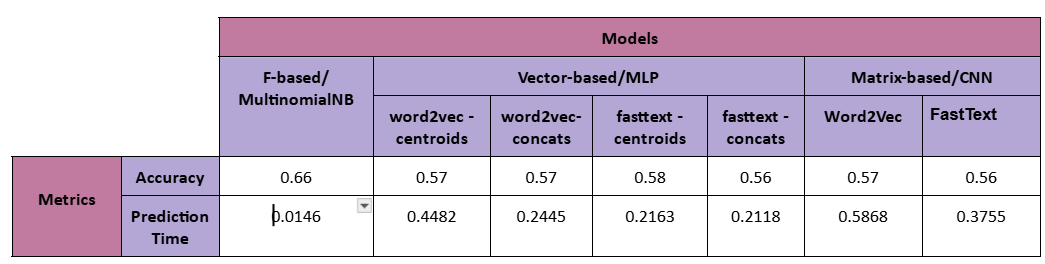

For this task, MultinomialNB with TF representation is the best choice due to its superior accuracy and efficiency.
If embeddings are necessary for a more complex representation, FastText-Centroids with MLP provides a reasonable trade-off between accuracy and prediction time, making it the second-best option.
Matrix-based CNNs may not be ideal here given their lower accuracy and higher prediction time.

In [23]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

# Custom preprocessor function to apply lemmatization
def preprocess(text):
    text = text.lower()  # Lowercase the text
    words = text.split()  # Split text into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return " ".join(words)

# Apply custom preprocessor to the text data
vectorizer = TfidfVectorizer(preprocessor=preprocess, max_features=5000)
X_train_tfidf = vectorizer.fit_transform(Xtxt_train)
X_test_tfidf = vectorizer.transform(Xtxt_test)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter=200)
param_grid = {'C': [0.1, 1.0, 10.0]}  # Regularization parameter

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6799771819737592

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.12      0.18       283
           1       0.69      0.88      0.77       940
           2       0.71      0.62      0.66       530

    accuracy                           0.68      1753
   macro avg       0.60      0.54      0.54      1753
weighted avg       0.65      0.68      0.64      1753

